**《深度学习之 PyTorch 实战》**

讲师作者：[土豆老师](https://iphysresearch.github.io)

# 计算性能

在深度学习中，数据集和模型通常都很大，导致计算量也会很大。因此，计算的性能非常重要。本讲将集中讨论影响计算性能的主要因素：命令式编程、符号编程、异步计算、自动并行和多 GPU 计算。通过学习本章，你可以进一步提高前几章中实现的那些模型的计算性能。例如，我们可以在不影响准确性的前提下，减少训练时间。

## 编译器和解释器

>(Restart your kernel here)

到目前为止，这本书主要关注命令式编程，它使用诸如 `print`、`+` 和 `if` 之类的语句来更改程序的状态。考虑下面这个简单的命令式程序的例子。

In [1]:
def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g

print(fancy_func(1, 2, 3, 4))

10


Python 是一种解释语言（interpreted language）。当评估上述 `fancy_func` 函数时，它按顺序执行函数体的操作。也就是说，它将计算 `e = add(a, b)`，并将结果存储为变量 `e`，从而更改程序的状态。接下来的两个语句 `f = add(c, d)` 和 `g = add(e, f)` 将类似地执行，执行加法并将结果存储为变量。 

下图说明了数据流。

![](https://i.loli.net/2021/06/02/6hUCIjPWYiatLKe.png)

尽管命令式编程很方便，但可能效率低下。一方面，即使 `add` 函数在 `fancy_func` 中被重复调用，Python 也会单独执行这三个函数调用。如果在一个 GPU（甚至多个GPU）上执行这些命令，那么Python解释器产生的开销可能会非常大。此外，它需要保存e和f的变量值，直到 `fancy_func` 中的所有语句都执行完毕。这是因为我们不知道在执行语句 `e = add(a, b)` 和 `f = add(c, d)` 之后，程序的其他部分是否会使用变量 `e` 和 `f`。


### 符号式编程

考虑另一种选择符号式编程（symbolic programming），通常只在完全定义了过程之后才执行计算。这个策略被多个深度学习框架使用，包括 Theano 和  TensorFlow（后者已经获得了命令式编程扩展）。通常包括以下步骤：

1. 定义要执行的操作。

2. 将操作编译成可执行程序。

3. 提供所需的输入并调用编译后的程序供执行。

这允许进行大量优化。首先，在许多情况下，我们可以跳过 Python 解释器。从而消除在多个更快的 GPU 上与在 CPU 上的单个 Python 线程搭配使用时可能出现的性能瓶颈。其次，编译器可能会优化并将上述代码重写为 `print((1 + 2) + (3 + 4))` 甚至 `print(10)`。这是可能的，因为编译器在将其转换为机器指令之前可以看到完整的代码。例如，只要不再需要某个变量，它就可以释放内存（或者从不分配内存）。或者它可以将代码转换为一个完全等价的片段。为了获得更好的想法，请考虑下面的命令式编程的模拟。

In [2]:
def add_():
    return '''
def add(a, b):
    return a + b
'''

def fancy_func_():
    return '''
def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
'''

def evoke_():
    return add_() + fancy_func_() + 'print(fancy_func(1, 2, 3, 4))'

prog = evoke_()
print(prog)
y = compile(prog, '', 'exec')
exec(y)


def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
print(fancy_func(1, 2, 3, 4))
10


命令式（解释式）编程和符号式编程的区别如下：

- 命令式编程更容易。在 Python 中使用命令式编程时，大多数代码都是简单易懂的。调试命令式编程代码也更容易。这是因为更容易获取和打印所有相关的中间变量值，或者使用 Python 的内置调试工具。

- 符号式编程更高效，更易于移植。符号式编程使得在编译期间优化代码更加容易，同时还能够将程序移植到独立于 Python 的格式中。这允许程序在非 Python 环境中运行，从而避免了与 Python 解释器相关的任何潜在性能问题。

### 混合式编程

历史上，大多数深度学习框架在命令式方法和符号式方法之间进行选择。例如，Theano、TensorFlow（灵感来自前者）、Keras 和 CNTK 采用了符号式方法。相反地，Chainer 和 PyTorch 采取了命令式方法。在后来的更新版中，tensorflow2.0 和 Keras 增加了命令式方法。MXNet 直接使用混合式编程。

如上所述，PyTorch 基于命令式编程并使用动态计算图。为了利用符号式编程的可移植性和效率，开发人员考虑了是否有可能将两种编程模型的优点结合起来。这就产生了 `torchscript`，它允许用户使用纯命令式编程进行开发和调试，同时能够将大多数程序转换为符号式程序，以便在需要产品级计算性能和部署时运行。

### Sequential 的混合式编程

要了解混合式编程的工作原理，最简单的方法是考虑具有多层的深层网络。按照惯例，Python 解释器将需要为所有层执行代码以生成指令，然后可以将该指令转发到 CPU 或 GPU。对于单个（快速）计算设备，这不会导致任何重大问题。另一方面，如果我们使用高级的 8-GPU 服务器，比如 AWS P3dn.24xlarge 实例，Python 将很难让所有 GPU 保持忙碌。单线程 Python 解释器成为这里的瓶颈。让我们看看如何通过用 HybridSequential 替换代码重要部分的 Sequential 来解决问题。我们首先定义一个简单的多层感知机。

In [1]:
import torch
from torch import nn
import dl4wm
import time

# 生产网络的工厂
def get_net():
    net = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128),
                        nn.ReLU(), nn.Linear(128, 2))
    return net

x = torch.randn(size=(1, 512))
net = get_net()
net(x)

tensor([[0.1397, 0.0704]], grad_fn=<AddmmBackward>)

通过使用 `torch.jit.script` 函数转换模型，我们可以编译和优化多层感知机的计算。模型的计算结果保持不变。

In [3]:
net = torch.jit.script(net)
net(x)

tensor([[0.1397, 0.0704]], grad_fn=<AddmmBackward>)

编写与以前相同的代码，并使用 `torch.jit.script` 简单地转换模型。一旦发生这种情况，网络将得到优化（我们将在下面对性能进行基准测试）。

#### 通过混合式编程加速

为了证明通过编译获得的性能改进，我们比较了混合编程前后执行 `net(x)` 所需的时间。让我们先定义一个函数来度量这个时间。当我们开始衡量（和改进）性能时，它在本讲中将非常有用。

In [5]:
# 本类将保存在 dl4wm 包中方便以后使用
class Benchmark():
    """Benchmark programs."""
    def __init__(self, prefix=None):
        self.prefix = prefix + ' ' if prefix else ''

    def __enter__(self):
        self.start = time.time()

    def __exit__(self, *args):
        print('%stime: %.4f sec' % (self.prefix, time.time() - self.start))

现在我们可以调用网络两次，一次使用 `torchscript`，一次不使用 `torchscript`。

In [6]:
net = get_net()
with Benchmark('无torchscript'):
    for i in range(1000):
        net(x)

net = torch.jit.script(net)
with Benchmark('有torchscript'):
    for i in range(1000):
        net(x)

无torchscript time: 1.8902 sec
有torchscript time: 1.8497 sec


从上面的结果中可以看到，使用 `nn.Sequential` 函数编写了 `torch.jit.script` 实例的脚本之后，通过使用符号式编程来提高计算性能。

### 小结

- 命令式编程使设计新模型变得容易，因为它可以用控制流编写代码，并且能够使用大量Python软件生态。

- 符号式编程要求我们在执行程序之前指定并编译程序。其好处是提高了性能。

## 异步计算

>(Restart your kernel here)

今天的计算机是高度并行的系统，由多个 CPU 核（通常每个核有多个线程）、每个 GPU 有多个处理单元，每个设备通常有多个 GPU 组成。简而言之，我们可以同时处理许多不同的事情，且通常是在不同的设备上。不幸的是，Python 不是编写并行和异步代码的好方法，至少在没有额外帮助的情况下不是好方法。毕竟，Python 是单线程的，这在将来是不太可能改变。诸如 MXNet 和 TensorFlow 之类的深度学习框架采用了一种异步编程（asynchronous programming）模型来提高性能，而 PyTorch 则使用 Python 自己的调度器来实现不同的性能权衡。对于 PyTorch，默认情况下，GPU 操作是异步的。当你调用一个使用GPU的函数时，操作会排队到特定的设备上，但不一定要等到以后才执行。这允许我们并行执行更多的计算，包括在 CPU 或其他 GPU 上的操作。

因此，了解异步编程是如何工作的，通过主动减少计算需求和相互依赖，有助于我们开发更高效的程序。这使我们能够减少内存开销并提高处理器利用率。

In [3]:
import os
import subprocess
import numpy
import torch
from torch import nn
import dl4wm

### 通过后端异步处理

作为热身，考虑一个简单问题：我们要生成一个随机矩阵并将其相乘。让我们在 NumPy 和 PyTorch 张量中都这样做，看看它们的区别。请注意，PyTorch 的 tensor 是在GPU上定义的。

In [6]:
# GPU计算热身
device = dl4wm.try_gpu()
a = torch.randn(size=(1000, 1000), device=device)
b = torch.mm(a, a)

with dl4wm.Benchmark('numpy'):
    for _ in range(10):
        a = numpy.random.normal(size=(1000, 1000))
        b = numpy.dot(a, a)

with dl4wm.Benchmark('torch'):
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)

numpy time: 0.9546 sec
torch time: 0.0015 sec


通过 PyTorch 的基准输出快了几个数量级。NumPy 点积是在CPU上执行的，而 PyTorch 矩阵乘法是在GPU上执行的，后者的速度要快得多。但巨大的时差表明一定有其他原因。默认情况下，GPU 操作在 PyTorch 中是异步的。强制 PyTorch 在返回之前完成所有计算。这显示了之前发生的情况：计算由后端执行，而前端将控制权返回给 Python。

In [9]:
with dl4wm.Benchmark():
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)
    torch.cuda.synchronize()

time: 0.0221 sec


广义地说，PyTorch 有一个用于与用户直接交互的前端（例如通过 Python），还有一个由系统用来执行计算的后端。如下图所示，用户可以用各种前端语言编写 PyTorch 程序，如 Python 和 C++。不管使用的前端编程语言，PyTorch 的执行主要发生在 C++ 实现的后端。由前端语言发出的操作被传递到后端执行。后端管理自己的线程，这些线程不断收集和执行排队的任务。请注意，要使其工作，后端必须能够跟踪计算图中各个步骤之间的依赖关系。因此，不可能并行化相互依赖的操作。

让我们看另一个简单例子，以便更好地理解依赖关系图。

In [10]:
x = torch.ones((1, 2), device=device)
y = torch.ones((1, 2), device=device)
z = x * y + 2
z

tensor([[3., 3.]], device='cuda:0')

![](https://i.loli.net/2021/06/02/Mdl2gmbBZ19xqNO.png)


(后端跟踪计算图中各个步骤之间的依赖关系)

上面的代码片段在上图中进行了说明。每当 Python 前端线程执行前三条语句中的一条语句时，它只是将任务返回到后端队列。当最后一个语句的结果需要被打印出来时，Python 前端线程将等待 C++ 后端线程完成变量z的结果计算。这种设计的一个好处是 Python 前端线程不需要执行实际的计算。因此，不管 Python 的性能如何，对程序的整体性能几乎没有影响。 

下图演示了前端和后端如何交互。

![](https://i.loli.net/2021/06/02/AVftDwLZbndP8Ms.png)


### 小结

- 深度学习框架可以将 Python 前端与执行后端解耦。这允许将命令快速异步插入后端。

- 异步导致了一个相当灵活的前端。但是，请注意不要过度填充任务队列，因为它可能会导致内存消耗过多。建议对每个小批量进行同步，以保持前端和后端大致同步。

- 芯片供应商提供了复杂的性能分析工具，以获得对深度学习效率更细粒度的洞察。

## 自动并行

>(Restart your kernel here)

深度学习框架（例如，PyTorch 和 MxNet）会在后端自动构建计算图。利用计算图，系统可以了解所有依赖关系，并且可以选择性地并行执行多个不相互依赖的任务以提高速度。

通常，单个操作符将使用所有 cpu 或单个 GPU 上的所有计算资源。例如，dot 操作符将使用所有 CPU 上的所有核心（和线程），即使一台机器上有多个 CPU 处理器。这同样适用于单个 GPU。因此，对于单设备计算机来说，并行化并不是很有用。有了多个设备，并行化就重要了。虽然并行化通常在多个 GPU 之间，但添加本地 CPU 将略微提高性能。借助自动并行化框架的便利性，我们可以在几行 Python 代码中实现相同的目标。更广泛地说，我们对自动并行计算的讨论集中在使用 CPU 和 GPU 的并行计算，以及计算和通信的并行化。

请注意，我们至少需要两个 GPU 来运行本节中的实验。

In [15]:
import torch
import dl4wm

### 基于GPU的并行计算

让我们从定义一个参考工作负载用于测试开始：下面的 `run` 函数使用分配到两个变量（`x_gpu1` 和 `x_gpu2`）的数据在我们选择的设备上执行 10 次矩阵-矩阵乘法。

```python
def try_all_gpus():  # 本函数将保存在 dl4wm 包中方便以后使用
    """Return all available GPUs, or [mx.cpu()] if there is no GPU."""
    devices = []
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            devices.append(torch.device('cuda:{}'.format(i)))
        return devices
    else:
        return [torch.device('cpu')]

```

In [2]:
devices = dl4wm.try_all_gpus()

def run(x):
    return [x.mm(x) for _ in range(50)]

x_gpu1 = torch.rand(size=(4000, 4000), device=devices[0])
x_gpu2 = torch.rand(size=(4000, 4000), device=devices[1])

现在我们将函数应用于数据。为了确保缓存在结果中不起作用，我们通过在测量之前对其中任何一个设备执行一次传递来预热设备。`torch.cuda.synchronize()` 等待 CUDA 设备上所有流中的所有核心计算完成。它接受一个 `device` 参数，代表这个设备需要同步。如果 `device` 参数是 `None`（默认值），它将使用 `current_device()` 给出的当前设备。

In [6]:
run(x_gpu1)
run(x_gpu2)  # 预热设备
torch.cuda.synchronize()
torch.cuda.synchronize()

with dl4wm.Benchmark('GPU1 time'):
    run(x_gpu1)
    torch.cuda.synchronize()

with dl4wm.Benchmark('GPU2 time'):
    run(x_gpu2)
    torch.cuda.synchronize()

GPU1 time time: 0.6114 sec
GPU2 time time: 0.0025 sec


如果我们删除两个任务之间的 synchronize 语句，系统就可以在两个设备上自动并行计算。

In [7]:
with dl4wm.Benchmark('GPU1 & GPU2'):
    run(x_gpu1)
    run(x_gpu2)
    torch.cuda.synchronize()

GPU1 & GPU2 time: 0.6059 sec


在上述情况下，总执行时间小于其部分的总和，因为深度学习框架自动调度两个 GPU 设备上的计算，而不需要用户编写复杂的代码。

### 并行计算与通信

在许多情况下，我们需要在不同的设备之间移动数据，比如在 CPU 和 GPU 之间，或者在不同的 GPU 之间。例如，当我们想要执行分布式优化时，需要聚合多个加速卡上的梯度时，就会遇到这种情况。让我们通过在 GPU 上计算，然后将结果复制回 CPU 来模拟这个过程。

In [8]:
def copy_to_cpu(x, non_blocking=False):
    return [y.to('cpu', non_blocking=non_blocking) for y in x]

with dl4wm.Benchmark('在GPU1上运行'):
    y = run(x_gpu1)
    torch.cuda.synchronize()

with dl4wm.Benchmark('复制到CPU'):
    y_cpu = copy_to_cpu(y)
    torch.cuda.synchronize()

在GPU1上运行 time: 0.7081 sec
复制到CPU time: 2.1010 sec


这有点低效。请注意，我们可能已经开始将 `y` 的部分复制到 CPU，而列表的其余部分仍在计算中。这种情况会发生，例如，当我们计算一个小批量的（Backprop）梯度时。某些参数的梯度将比其他参数的梯度更早可用。因此，在 GPU 仍在运行时开始使用 PCI-Express 总线带宽对我们是有利的。在 PyTorch 中，`to()` 和 `copy_()` 等函数都允许显式的 `non_blocking` 参数，这允许调用方在不需要同步时绕过同步。设置 `non_blocking=True` 允许我们模拟这个场景。

In [9]:
with dl4wm.Benchmark('在GPU1上运行并复制到CPU'):
    y = run(x_gpu1)
    y_cpu = copy_to_cpu(y, True)
    torch.cuda.synchronize()

在GPU1上运行并复制到CPU time: 2.7991 sec


两个操作所需的总时间少于它们各部分的总和。请注意，此任务与并行计算不同，因为它使用不同的资源：CPU 和 GPU 之间的总线。事实上，我们可以在两个设备上同时进行计算和通信。如上所述，计算和通信之间存在依赖关系：必须先计算 `y[i]`，然后才能将其复制到CPU。幸运的是，系统可以在计算 `y[i]` 的同时复制 `y[i-1]`，以减少总的运行时间。

最后，我们给出了一个简单的两层多层感知机在 CPU 和两个 GPU 上训练时的计算图及其依赖关系的例子，如下图所示。手动调度由此产生的并行程序将是相当痛苦的。这就是基于图的计算后端进行优化的优势所在。

![](https://i.loli.net/2021/06/02/jsJcy1v8QeRMTVr.png)

(一个 CPU 和两个 GPU 上的两层多层感知机的计算图及其依赖关系)

### 小结

- 现代系统有多种设备，如多个 GPU 和 CPU。它们可以并行、异步地使用。

- 现代系统还拥有各种通信资源，如 PCI Express、存储（通常是固态驱动器或通过网络）和网络带宽。它们可以并行使用，达到最高效率。

- 后端可以通过自动并行计算和通信来提高性能。

## 多 GPU 训练

>(Restart your kernel here)

到目前为止，我们讨论了如何在 CPU 和 GPU 上高效地训练模型。我们甚至在「自动并行」节中展示了深度学习框架如何使它们之间的计算和通信自动并行化。我们还在「深度学习计算」节中展示了如何使用 `nvidia-smi` 命令列出计算机上所有可用的 GPU。我们没有讨论的是如何真正实现深度学习训练的并行化。我们暗示了一种方法，即以某种方式将数据分割到多个设备上，并使其正常工作。本节将详细介绍如何从零开始并行训练网络。我们假设你熟悉小批量随机梯度下降算法，如 `sec_minibatch_sgd` 中描述的算法。

### 拆分问题

让我们从一个简单的计算机视觉问题和一个稍微旧点的网络开始，例如，有多个卷积层和池化层，最后可能有几个全连接的层。也就是说，让我们从一个看起来非常类似于 LeNet [LeCun et al., 1998] 或 AlexNet [Krizhevsky et al., 2012] 的网络开始。假设有多个 GPU（如果是桌面服务器则为 2 个，AWS g4dn.12xlarge实例上为4个，p3.16xlarge上为8个，p2.16xlarge上为16个），我们希望以一种方式对训练进行拆分，以实现良好的加速比，同时受益于简单且可重复的设计选择。毕竟，多个GPU同时增加了内存和计算能力。简而言之，给出一小批量我们想要分类的训练数据，我们有以下选择。

首先，我们可以在多个 GPU 之间拆分网络。也就是说，每个 GPU 将流入特定层的数据作为输入，跨多个后续层处理数据，然后将数据发送到下一个 GPU。与单个 GPU 所能处理的数据相比，这使我们可以用更大的网络处理数据。此外，每个 GPU 的显存占用可以得到很好的控制（它只是整个网络占用的一小部分）。

然而，层（以及 GPU）之间的接口需要紧密同步。这可能很棘手，特别是在计算工作负载在层之间没有正确匹配的时候。对于大量的 GPU 来说，这个问题更加严重。层之间的接口还需要大量的数据传输，例如激活值和梯度。这可能会超出 GPU 总线的带宽。此外，计算密集型的操作顺序对于拆分来说是非常重要的。有关这方面的最佳努力，请参见 [Mirhoseini et al., 2017] 。这仍然是一个困难的问题，目前还不清楚是否有可能在特定问题上实现良好的（线性）缩放。除非有优秀的框架或操作系统支持将多个GPU连接在一起，否则我们不建议使用它。

第二，我们可以拆分工作。例如，我们可以将问题分散到 4 个GPU，每个GPU生成16个通道的数据，而不是在单个 GPU 上计算 64 个通道。同样，对于全连接的层，我们可以拆分输出单元的数量。 下图（来自 [Krizhevsky et al., 2012] ）说明了这种设计，这种策略用于显存非常小（当时为 2 GB）的 GPU。这允许在计算方面进行良好的缩放，前提是通道（或单元）的数量不太小。此外，由于可用显存呈线性扩展，多个 GPU 可以处理越来越大的网络。

![](https://i.loli.net/2021/06/03/wNxIEq2cuyFmWBn.png)

（由于GPU显存有限，原有AlexNet设计中存在模型并行性问题）

但是，我们需要非常多的同步或阻塞操作，因为每一层都依赖于所有其他层的结果。此外，需要传输的数据量可能比跨 GPU 拆分层时还要大。因此，由于其带宽成本和复杂性，我们不推荐这种方法。

最后，我们可以跨多个 GPU 对数据进行拆分。通过这种方式，所有GPU执行相同类型的工作，尽管观察结果不同。在每个小批量的训练数据之后，梯度在 GPU 上聚合。这是最简单的方法，可以应用于任何情况。我们只需要在每个小批处理之后进行同步。也就是说，当其他梯度参数仍在计算时，开始交换梯度参数是非常可取的。此外，GPU 数量越多，小批量越大，从而提高了训练效率。但是，添加更多 GPU 并不能让我们训练更大的模型。

![](https://i.loli.net/2021/06/03/ge6npUjRCAw1Flx.png)

（在多个GPU上并行化。从左到右：原始问题、网络并行、分层并行、数据并行。）

上图中描述了多个 GPU 上不同并行方式的比较。总的来说，数据并行是最方便的方法，只要我们能访问有足够大显存的 GPU。有关分布式训练并行的详细描述，请参见 [Li et al., 2014] 。GPU 显存在深度学习的早期曾经是一个问题。到目前为止，除了最不寻常的情况外，这个问题已经解决了。下面我们将重点讨论数据并行性。

### 数据并行性

假设机器上有 $k$ 个GPU。给定要训练的模型，每个 GPU 将独立地维护一组完整的模型参数，尽管 GPU 上的参数值是相同且同步的。例如，下图演示了在 $k=2$ 时使用数据并行的训练。

![](https://i.loli.net/2021/06/03/eiTOPCaHkgpwxdS.png)

(利用两个GPU上的数据并行计算小批量随机梯度下降)

一般来说，训练过程如下：

- 在训练的任何迭代中，给定一个随机的小批量，我们将该小批量中的样本分成 $k$ 个部分，并将它们均匀地分在多个 GPU 上。

- 每个GPU根据分配给它的小批量子集计算模型参数的损失和梯度。

- 将 $k$ 个 GPU 中每个 GPU 的局部梯度聚合以获得当前的小批量随机梯度。

- 聚合梯度被重新分配到每个 GPU。

- 每个 GPU 使用这个小批量随机梯度来更新它维护的完整的模型参数集。

请注意，在实践中，当在 $k$ 个 GPU 上训练时，我们将小批量大小增加 $k$ 倍，这样每个 GPU 都有相同的工作量，就像我们只在单个 GPU 上训练一样。在 16-GPU 服务器上，这可以大大增加小批量大小，我们可能需要相应地提高学习速率。还请注意，「批量归一化」节中的批量归一化需要调整，例如，为每个 GPU 保留单独的批量归一化参数。下面我们将使用一个简单网络来演示多 GPU 训练。

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
import dl4wm

### 简单网络

我们使用「卷积神经网络（LeNet）」节中介绍的 LeNet（稍加修改）。我们从零开始定义它，从而详细说明参数交换和同步。

In [2]:
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

### 数据同步

对于高效的多 GPU 训练，我们需要两个基本操作。首先，我们需要有能力将参数分发给多个设备并附加梯度（`get_params`）。如果没有参数，就不可能在 GPU 上评估网络。第二，我们需要跨多个设备对参数求和的能力，也就是说，我们需要一个 `allreduce` 函数。

In [3]:
def get_params(params, device):
    new_params = [p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

让我们通过将模型参数复制到一个 GPU 来尝试一下。

In [4]:
new_params = get_params(params, dl4wm.try_gpu(0))
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


由于我们还没有进行任何计算，偏置参数的梯度仍然为零。现在假设有一个向量分布在多个 GPU 上。下面的 `allreduce` 函数将所有向量相加，并将结果广播回所有 GPU。请注意，要使其工作，我们需要将数据复制到累积结果的设备。

In [5]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)

让我们通过在不同设备上创建具有不同值的向量并聚合它们来测试这一点。

In [6]:
data = [torch.ones((1, 2), device=dl4wm.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


### 分发数据

我们需要一个简单的实用函数来将一个小批量均匀地分布在多个 GPU 上。例如，在有两个 GPU 的时候，我们希望将一半的数据复制到其中一个 GPU。因为深度学习框架中的内置函数更方便、更简洁，所以我们使用它在 4×5 矩阵上进行了尝试。

In [7]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


为了以后的复用，我们定义了一个 `split_batch` 函数，该函数同时拆分数据和标签。

### 训练

现在我们可以在一个小批量上实现多 GPU 训练。它的实现主要基于本节描述的数据并行方法。我们将使用刚才讨论的辅助函数 `allreduce` 在多个 GPU 之间同步数据。注意，我们不需要编写任何特定的代码来实现并行性。由于计算图在小批量内的设备之间没有任何依赖关系，因此它是自动并行执行的。

In [8]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = dl4wm.split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [
        loss(lenet(X_shard, device_W),
             y_shard).sum() for X_shard, y_shard, device_W in zip(
                 X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        dl4wm.sgd(param, lr, X.shape[0])  # 在这里，我们使用全尺寸的小批量

现在，我们可以定义训练函数。它与前几章中使用的略有不同：我们需要分配 GPU 并将所有模型参数复制到所有设备。显然，每个小批量都是使用 `train_batch` 函数来处理多个 GPU 的。为了方便（和代码的简洁性），我们在一个 GPU 上计算精度，尽管这是低效的，因为其他 GPU 是空闲的。

In [9]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = dl4wm.load_data_fashion_mnist(batch_size)
    devices = [dl4wm.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到`num_gpus`个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = dl4wm.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = dl4wm.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU 0上评估模型
        animator.add(epoch + 1, (dl4wm.evaluate_accuracy_gpus(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
#         animator.add(epoch + 1, (dl4wm.evaluate_accuracy_gpu(
#             test_iter, lambda x: lenet(x, device_params[0]), devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

让我们看看这在单个 GPU 上运行得有多好。我们首先使用批量大小 256，学习率为 0.001。

test acc: 0.73, 2.8 sec/epoch on [device(type='cuda', index=0)]


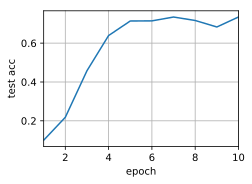

In [48]:
train(num_gpus=1, batch_size=256, lr=0.001)

- 试一试：

通过保持批量大小和学习率不变，并将 GPU 数增加到2个，我们可以看到测试精度与之前的实验基本相同。在优化算法方面，它们是相同的。不幸的是，这里没有任何有意义的加速：模型实在太小了；而且，我们只有一个很小的数据集，在这个数据集中，我们实现多GPU训练的简单方法受到了巨大的 Python 开销的影响。在未来，我们将遇到更复杂的模型和更复杂的并行化方法。尽管如此，让我们看看 Fashion-MNIST 会发生什么。

### 小结

- 有多种方法可以在多个GPU上拆分深度网络训练。我们可以在层之间、跨层或跨数据拆分它们。前两者需要经过严格编排的数据传输。数据并行是最简单的策略。

- 数据并行训练非常简单。但是，它增加了有效的小批量大小以提高效率。

- 在数据并行中，数据跨多个GPU拆分，其中每个GPU执行其自己的前向传播和反向传播，随后聚合梯度并将结果广播回GPU。

- 对于较大的小批量，我们可以使用稍微提高的学习率。

## 多 GPU 计算的简洁实现

>(Restart your kernel here)

为每一个新模型从零开始实现并行性并不有趣。此外，优化同步工具以获得高性能也有很大的好处。下面我们将展示如何使用深度学习框架的高级 API 来实现这一点。数学和算法与「多 GPU 训练」节 中的相同。毫不奇怪，你至少需要两个 GPU 来运行本节的代码。

In [1]:
import torch
from torch import nn
import dl4wm

### 简单网络

让我们使用一个比上一节的 LeNet 稍微有意义的网络，它仍然足够容易和快速地训练。我们选择了 ResNet-18 [He et al., 2016a]。因为输入的图像很小，所以我们稍微修改一下。与「残差网络（ResNet）」节 的区别在于，我们在开始时使用了更小的卷积核、步长和填充。此外，我们删除了最大池化层。

```python
def resnet18(num_classes, in_channels=1):
    """A slightly modified ResNet-18 model."""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # This model uses a smaller convolution kernel, stride, and padding and
    # removes the maximum pooling layer
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(FlattenLayer(),#nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net
```

### 网络初始化

我们将初始化训练部分代码内的网络。有关初始化方法的复习内容，请参见「数值稳定性和模型初始化」节。

In [4]:
net = dl4wm.resnet18(10)
# 获取GPU列表
devices = dl4wm.try_all_gpus()
# 我们将在训练代码实现中初始化网络

### 训练

如前所述，训练代码需要执行几个基本功能才能实现高效并行：

- 需要在所有设备上初始化网络参数。

- 在数据集上迭代时，要将小批量划分到所有设备上。

- 我们跨设备并行计算损失及其梯度。

- 聚合梯度，并相应地更新参数。

最后我们计算精度（同样是并行地）来报告网络的最终性能。训练代码与前几章中的实现非常相似，只是我们需要拆分和聚合数据。

In [7]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = dl4wm.load_data_fashion_mnist(batch_size)
    devices = [dl4wm.try_gpu(i) for i in range(num_gpus)]

    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)

    net.apply(init_weights)
    # 在多个GPU上设置模型
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = dl4wm.Timer(), 10
    animator = dl4wm.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (dl4wm.evaluate_accuracy_gpus(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

让我们看看这在实践中是如何运作的。作为热身，我们在单个 GPU 上训练网络。

test acc: 0.88, 23.9 sec/epoch on [device(type='cuda', index=0)]


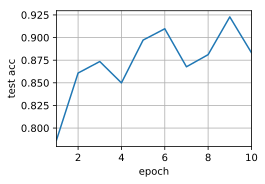

In [8]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

接下来我们使用 2 个 GPU 进行训练。与上一节中评估的 LeNet 相比，ResNet-18 的模型要复杂得多。这就是并行化显示其优势的地方，计算时间明显大于同步参数的时间。这提高了可伸缩性，因为并行化的开销不太相关。

test acc: 0.93, 17.6 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


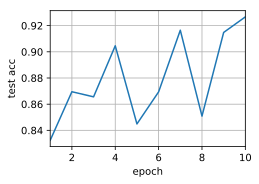

In [9]:
train(net, num_gpus=2, batch_size=256, lr=0.1)

## *多 GPU 模型的保存与加载


我们现在来尝试一下按照「读取和存储」节所推荐的方式进行一下模型的保存与加载。 

保存模型:

In [ ]:
torch.save(net.state_dict(), "./multi_GPU_model.pt")

加载模型前我们一般要先进行一下模型定义，此时的 `new_net` 并没有使用多 GPU:

In [ ]:
new_net = resnet18(10)
new_net.load_state_dict(torch.load("./multi_GPU_model.pt"))

然后我们发现报错了:

事实上 `DataParallel` 也是一个 `nn.Module`，只是这个类其中有一个 module 就是传入的实际模型。因此当我们调用 `DataParallel` 后，模型结构变了（在外面加了一层而已，从「多 GPU 计算」节两个输出可以对比看出来）。所以直接加载肯定会报错的，因为模型结构对不上。

所以正确的方法是保存的时候只保存 `net.module`:

In [ ]:
# Way 1
torch.save(net.module.state_dict(), "./multi_GPU_model.pt")
new_net.load_state_dict(torch.load("./multi_GPU_model.pt")) # 加载成功

或者先将 `new_net` 用 `DataParallel` 包括以下再用上面报错的方法进行模型加载:

In [ ]:
# Way 2
torch.save(net.state_dict(), "./multi_GPU_model.pt")
new_net = torch.nn.Linear(10, 1)
new_net = torch.nn.DataParallel(new_net)
new_net.load_state_dict(torch.load("./multi_GPU_model.pt")) # 加载成功

注意这两种方法的区别，推荐用第一种方法，因为可以按照普通的加载方法进行正确加载。

### 小结

- 在可以找到数据的设备上自动评估数据。

- 在尝试访问每台设备上的参数之前，请注意初始化该设备上的网络。否则，你将遇到错误。

- 优化算法在多个 GPU 上自动聚合。